TODO:  
Clean up the first rolling std /mean charting (it's redundant to get_stationarity()  
Refine this - need to get stationarity to below p-value of .05.  How do we do that?  
WTF is seasonal_decompose? <- is it relevant to MSFT?  
Add functionality to include multiple stocks and timeframes.  

In [10]:
import numpy as np
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [12]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['Close'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

In [2]:
raw_df = pd.read_csv(
    Path("data.csv"),
    index_col="Date"
)
raw_df.head()

,Close
Date,
2021-07-19,274.766418
2021-07-20,277.057678
2021-07-21,279.120789
2021-07-22,283.822449
2021-07-23,287.323853


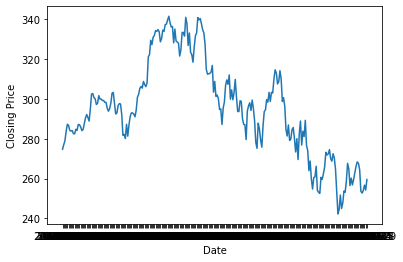

In [5]:
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.plot(raw_df)

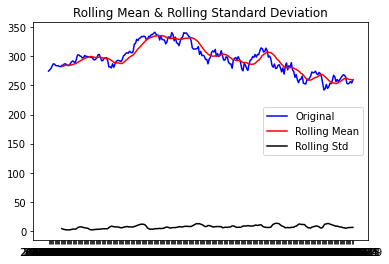

In [6]:
rolling_mean = raw_df.rolling(window = 12).mean()
rolling_std = raw_df.rolling(window = 12).std()
plt.plot(raw_df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

Horzontality is improved.
Rolling Std is decent, but rolling mean leaves something to be desired.

In [8]:
result = adfuller(raw_df['Close'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -1.5313831517569574
p-value: 0.5179333896603902
Critical Values:
	1%: -3.4565688966099373
	5%: -2.8730786194395455
	10%: -2.5729189953388762


The target p-value is < 0.05, so our result here still needs some work.

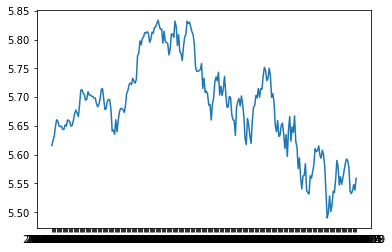

In [11]:
df_log = np.log(raw_df)
plt.plot(df_log)

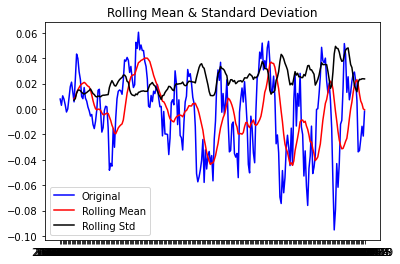

ADF Statistic: -4.6952914412346445
p-value: 8.588349580240536e-05
Critical Values:
	1%: -3.4577787098622674
	5%: -2.873608704758507
	10%: -2.573201765981991


In [13]:
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

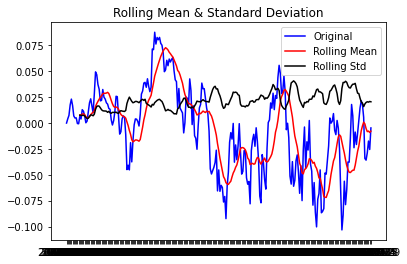

ADF Statistic: -3.537641407633762
p-value: 0.007071399145896257
Critical Values:
	1%: -3.4565688966099373
	5%: -2.8730786194395455
	10%: -2.5729189953388762


In [14]:
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

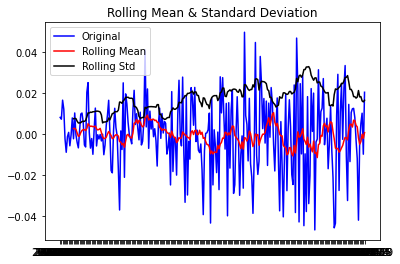

ADF Statistic: -16.745908135004065
p-value: 1.346276553696341e-29
Critical Values:
	1%: -3.4566744514553016
	5%: -2.8731248767783426
	10%: -2.5729436702592023


In [15]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

In [16]:
decomposition = seasonal_decompose(df_log) 
model = ARIMA(df_log, order=(2,1,2))
results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [ ]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log['Passengers'].iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)